# Experiments

For a full description of the experimental setup, see the [documentation](../docs/experimental-setup.md).

In [1]:
# General setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=["scenario", "preference_criteria", "objectives", "solver", "utility"])

# Prepare a dict to store the adaptations
adaptations = {}

## Scenario 1: Preference Criteria are Superset of Objectives (SUP)

In this first scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives do not include all preference criteria in the true preference function.

In [2]:
import experiments.user
import experiments.problem

# Get utility function
SCENARIO_1_PREFERENCE_CRITERIA = ["neck", "shoulder", "torso"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_1_PREFERENCE_CRITERIA,
    weights=1/3,
)

# Get MOO problem
SCENARIO_1_OBJECTIVES = ["neck", "shoulder"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_1_OBJECTIVES
)

# Prepare dict to store the results
adaptations["SUP"] = {}

### Our Solver: U-NSGA-III w/ AASF

Our suggested solver uses the genetic U-NSGA-III algorithm with the AASF decomposition technique.

In [3]:
import experiments.pareto_solver

def get_pareto_optimal_aasf_adaptations_and_utilities(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    pareto_solver = experiments.pareto_solver.ParetoSolver(problem, pop=100, n_gen=100, seed=42)
    pareto_front_adaptations = pareto_solver.get_adaptations(decomposition="aasf")
    utilities = [get_utility(adaptation) for adaptation in pareto_front_adaptations]
    if verbose:
        print(f"Adaptations (Ours (AASF)): {len(pareto_front_adaptations)} adaptations")
        print("Utilities (Ours (AASF)):", utilities)
        print("Max Utility Adaptation (Ours (AASF)):", pareto_front_adaptations[np.argmax(utilities)])
        print("Max Utility (Ours (AASF)):", np.max(utilities))
    return pareto_front_adaptations, utilities

adaptations_for_aasf_adaptations, utilities_for_aasf_adaptations = get_pareto_optimal_aasf_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)
adaptations["SUP"]["Ours (AASF)"] = []
for adaptation, utility in zip(adaptations_for_aasf_adaptations, utilities_for_aasf_adaptations):
    adaptations["SUP"]["Ours (AASF)"].append({
        "adaptation": adaptation,
        "utility": utility,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(adaptation)
            for preference_criteria in SCENARIO_1_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(adaptation)
            for objective in SCENARIO_1_OBJECTIVES
        },
    })

Adaptations (Ours (AASF)): 3 adaptations
Utilities (Ours (AASF)): [0.8802704924179034, 0.8700231379722703, 0.8623806963310363]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=9.807642394722166, y=5.985315961888588, z=14.102508315311496), rotation=Rotation(x=0.6355263109978029, y=0.6198955512599637, z=0.22815703064650844, w=0.3841591902832825))])
Max Utility (Ours (AASF)): 0.8802704924179034


We can also generate the entire Pareto frontier.

In [4]:
def get_pareto_optimal_adaptations_and_utilities(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    pareto_solver = experiments.pareto_solver.ParetoSolver(problem, pop=100, n_gen=100, seed=42)
    pareto_front_adaptations = pareto_solver.get_adaptations()
    utilities = [get_utility(adaptation) for adaptation in pareto_front_adaptations]
    if verbose:
        print(f"Adaptations (Ours (PF)): {len(pareto_front_adaptations)} adaptations")
        print("Utilities (Ours (PF)):", utilities)
        print("Max Utility Adaptation (Ours (PF)):", pareto_front_adaptations[np.argmax(utilities)])
        print("Max Utility (Ours (PF)):", np.max(utilities))
    return pareto_front_adaptations, utilities

pareto_front_adaptations, utilities_for_pareto_front_adaptations = get_pareto_optimal_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)
adaptations["SUP"]["Ours (PF)"] = []
for adaptation, utility in zip(pareto_front_adaptations, utilities_for_pareto_front_adaptations):
    adaptations["SUP"]["Ours (PF)"].append({
        "adaptation": adaptation,
        "utility": utility,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(adaptation)
            for preference_criteria in SCENARIO_1_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(adaptation)
            for objective in SCENARIO_1_OBJECTIVES
        },
    })

Adaptations (Ours (PF)): 5 adaptations
Utilities (Ours (PF)): [0.8700231379722703, 0.8802704924179034, 0.8461635646145993, 0.8910355494073863, 0.8623806963310363]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=-15.606332210073283, y=-13.628113330232878, z=-19.79615045376869), rotation=Rotation(x=0.43683948624245916, y=0.026316407425051758, z=0.12167580261783005, w=0.03575771701421536))])
Max Utility (Ours (PF)): 0.8910355494073863


### Baseline Solver 1: Static Weighted Sum (WS)

The first baseline solver is a static weighted sum with equal weights.

In [5]:
import experiments.weighted_sum_solver

def get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose = False, algo = "unsga3"):
    """Get the utility of the equally weighted sum adaptation."""
    equally_weighted_sum_solver = experiments.weighted_sum_solver.WeightedSumSolver(problem, weights=1/problem.n_obj, seed=42, algo=algo)
    equally_weighted_sum_adaptation = equally_weighted_sum_solver.get_adaptations()[0]
    equally_weighted_sum_utility = get_utility(equally_weighted_sum_adaptation)
    if verbose:
        print("Equally Weighted Sum Adaptation:", equally_weighted_sum_adaptation)
        print("Equally Weighted Sum Utility:", equally_weighted_sum_utility)
    return equally_weighted_sum_adaptation, equally_weighted_sum_utility

equally_weighted_sum_adaptation, equally_weighted_sum_utility = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)
adaptations["SUP"]["WS"] = [{
    "adaptation": equally_weighted_sum_adaptation,
    "utility": equally_weighted_sum_utility,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation)
        for preference_criteria in SCENARIO_1_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation)
        for objective in SCENARIO_1_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Equally Weighted Sum Utility: 0.8461635646145993


In [6]:
equally_weighted_sum_adaptation_nm, equally_weighted_sum_utility_nm = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True, algo="nm")
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "WS (NM)",
    "utility": equally_weighted_sum_utility_nm,
}, ignore_index=True)
adaptations["SUP"]["WS (NM)"] = [{
    "adaptation": equally_weighted_sum_adaptation_nm,
    "utility": equally_weighted_sum_utility_nm,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation_nm)
        for preference_criteria in SCENARIO_1_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation_nm)
        for objective in SCENARIO_1_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=0.09306487238849481, y=-19.327692681427934, z=0.24956363297199857), rotation=Rotation(x=0.8249033331535464, y=0.3023882995904344, z=0.05397092199059141, w=0.9917847547031233))])
Equally Weighted Sum Utility: 0.8340803255941681


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

The second baseline solver is a single-objective solver that is used for all objectives in the utility function.

In [7]:
import experiments.single_objectives_solver

def get_single_objective_adaptations_and_utilities(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    single_objectives_solver = experiments.single_objectives_solver.SingleObjectivesSolver(problem, pop=100, n_gen=100, seed=42)
    single_objective_adaptations = single_objectives_solver.get_adaptations()
    utilities = [get_utility(adaptation) for adaptation in single_objective_adaptations]
    if verbose:
        print(f"Adaptations (MSO): {len(single_objective_adaptations)} adaptations")
        print("Utilities (MSO):", utilities)
        print("Max Utility Adaptation (MSO):", single_objective_adaptations[np.argmax(utilities)])
        print("Max Utility (MSO):", np.max(utilities))
    return single_objective_adaptations, utilities

mso_adaptations, utilities_for_mso_adaptations = get_single_objective_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)
adaptations["SUP"]["MSO"] = []
for adaptation, utility in zip(mso_adaptations, utilities_for_mso_adaptations):
    adaptations["SUP"]["MSO"].append({
        "adaptation": adaptation,
        "utility": utility,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(adaptation)
            for preference_criteria in SCENARIO_1_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(adaptation)
            for objective in SCENARIO_1_OBJECTIVES
        },
    })

Adaptations (MSO): 2 adaptations
Utilities (MSO): [0.8623806963310363, 0.8700231379722703]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=-9.477930874322805, y=7.881054982152608, z=14.203510182051893), rotation=Rotation(x=0.03033422473386293, y=0.7783898701428106, z=0.04600264202175275, w=0.37517342090806194))])
Max Utility (MSO): 0.8700231379722703


### Baseline Solver 3: Random Solver (RND)

The third baseline solver is a random solver that returns a random adaptation.

In [8]:
import experiments.random_solver

def get_random_adaptation_and_utility(problem, get_utility, verbose = False):
    """Get the utility of a random adaptation."""
    random_solver = experiments.random_solver.RandomSolver(problem=problem, seed=42)
    random_adaptation = random_solver.get_adaptations(n_adaptations=1)[0]
    utility = get_utility(random_adaptation)
    if verbose:
        print("Adaptation (RND):", random_adaptation)
        print("Utility (RND):", utility)
    return random_adaptation, utility

random_adaptation, utility_for_random_adaptation = get_random_adaptation_and_utility(problem, get_utility, verbose=True)

Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=10.958241942238534, y=-2.4448624099179064, z=14.343916796455296), rotation=Rotation(x=0.6973680290593639, y=0.09417734788764953, z=0.9756223516367559, w=0.761139701990353))])
Utility (RND): 0.9106866996687881


We can also run the random solver a few times and calculate the average utility of the returned solutions.

In [9]:
def get_random_adaptation_and_expected_utility(problem, get_utility, n_trials = 100, verbose = False):
    """Get the expected utility of a random adaptation."""
    random_solver = experiments.random_solver.RandomSolver(problem=problem, seed=42)
    random_adaptations = random_solver.get_adaptations(n_adaptations=n_trials)
    utilities = [get_utility(random_adaptation) for random_adaptation in random_adaptations]
    median_utility = np.median(utilities)
    median_utility_adaptation = random_adaptations[np.argmin(np.abs(utilities - median_utility))]
    if verbose:
        print("Median Utility Adaptation (RND):", median_utility_adaptation)
        print("Median Utility (RND):", median_utility)
    return median_utility_adaptation, median_utility

random_adaptation, expected_utility_for_random_adaptation = get_random_adaptation_and_expected_utility(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)
adaptations["SUP"]["RND"] = [{
    "adaptation": random_adaptation,
    "utility": expected_utility_for_random_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(random_adaptation)
        for preference_criteria in SCENARIO_1_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(random_adaptation)
        for objective in SCENARIO_1_OBJECTIVES
    },
}]

Median Utility Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=13.976353716922915, y=-17.710722393869585, z=12.03855414566705), rotation=Rotation(x=0.9277954301722804, y=0.7721083991043806, z=0.6981207839786372, w=0.8379802186553831))])
Median Utility (RND): 0.8766999184949436


### Results

The results of the experiments are shown in the following table.

In [10]:
# Show results
results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
1,SUP,"neck, shoulder, torso","neck, shoulder",Ours (PF),0.891036
0,SUP,"neck, shoulder, torso","neck, shoulder",Ours (AASF),0.880270
5,SUP,"neck, shoulder, torso","neck, shoulder",RND,0.876700
4,SUP,"neck, shoulder, torso","neck, shoulder",MSO,0.870023
2,SUP,"neck, shoulder, torso","neck, shoulder",WS,0.846164
3,SUP,"neck, shoulder, torso","neck, shoulder",WS (NM),0.834080


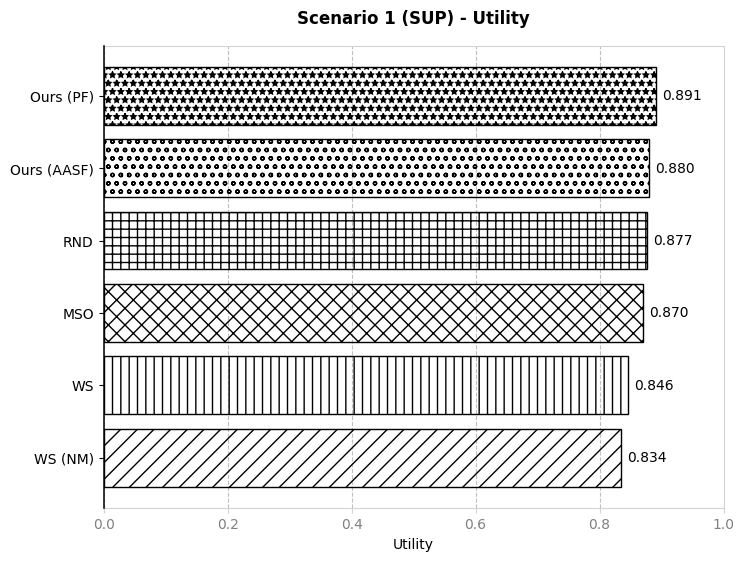

In [11]:
# Visualize results for scenario 1 in a horizontal bar chart
def visualize_results(data, title):
    """Visualize the results for scenario 1."""
    # Get figure
    fig, ax = plt.subplots(figsize=(8, 6))
    # Set title
    ax.set_title(title, fontweight="bold", pad=16)
    # Set x-axis
    ax.set_xlabel("Utility")
    # Set y-axis
    # ax.set_ylabel("Solver")
    # Set grid
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed', axis="x", alpha=0.5)
    # Set limits
    ax.set_xlim(0, 1)
    # Set spines to grey
    ax.spines["bottom"].set_color('lightgray')
    ax.spines["top"].set_color('lightgray')
    ax.spines["right"].set_color('lightgray')
    ax.spines["left"].set_color('k')
    # Set the left spine to be thick
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["left"].set_zorder(10)
    # Set the tick labels and axis labels color to grey
    ax.tick_params(axis="x", which="both", labelcolor='gray', color='lightgray')
    # Plot bars
    hatches = ["//", "||", "xx", "++", "oo", "**"]
    ax.barh(data["solver"], data["utility"],
        edgecolor="k",
        color="none",
        hatch=data["solver"].map(dict(zip(data["solver"].unique(), hatches))),
    )
    # Set y-axis
    ax.set_yticks(data["solver"])
    # Set y-tick labels and make label bold for only solver "Ours"
    ax.set_yticklabels(data["solver"])
    # Set labels
    for i, (solver, utility) in enumerate(zip(data["solver"], data["utility"])):
        ax.text(utility + 0.01, i, f"{utility:.3f}", ha="left", va="center", color="k")
    # Return figure
    return fig

def visualize_scenario_1(results):
    """Visualize the results for scenario 1."""
    # Get data
    data = results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 1 (SUP) - Utility")
    # Return figure
    return fig

fig_scenario_1 = visualize_scenario_1(results)


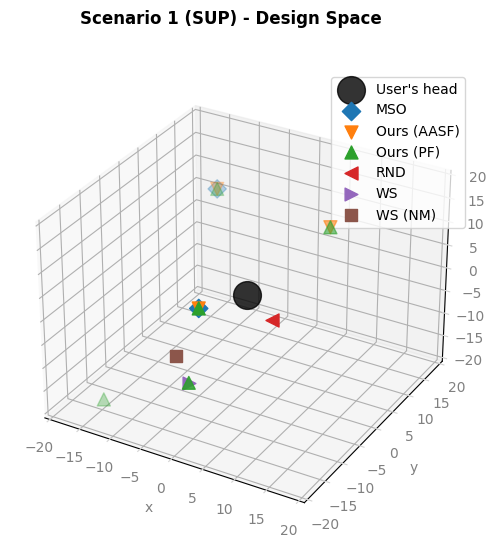

In [12]:
# Visualize the results in 3D
def visualize_results_3d(data, adaptations, title):
    """Visualize the results in 3D."""
    # Get figure
    fig = plt.figure(figsize=(8, 6))
    # Set title
    fig.suptitle(title, fontweight="bold")
    # Set axes
    ax = fig.add_subplot(111, projection="3d")
    # Set axes limits
    ax.set_xlim(problem.xl[0], problem.xu[0])
    ax.set_ylim(problem.xl[1], problem.xu[1])
    ax.set_zlim(problem.xl[2], problem.xu[2])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # Set grid
    ax.grid(color='gray', linestyle='dashed', alpha=0.5)
    # Set spines to grey
    ax.spines["bottom"].set_color('lightgray')
    ax.spines["top"].set_color('lightgray')
    ax.spines["right"].set_color('lightgray')
    ax.spines["left"].set_color('lightgray')
    # Set the tick labels and axis labels color to grey
    ax.tick_params(axis="x", which="both", labelcolor='gray', color='lightgray')
    ax.tick_params(axis="y", which="both", labelcolor='gray', color='lightgray')
    ax.tick_params(axis="z", which="both", labelcolor='gray', color='lightgray')
    # Set the tick labels and axis labels color to grey
    ax.xaxis.label.set_color('gray')
    ax.yaxis.label.set_color('gray')
    ax.zaxis.label.set_color('gray')
    # Plot points
    markers = ["D", "v", "^", "<", ">", "s"]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    # Add a sphere to the origin point to represent the user's head
    ax.scatter(0, 0, 0, s=400, alpha=0.8, c="k", marker="o", label="User's head")
    # Plot points
    for solver, solver_data in data.groupby("solver"):
        # Get adaptation
        suggested_adaptations = adaptations[solver]
        # Get color
        color = colors.pop(0)
        # Get marker
        marker = markers.pop(0)
        # Plot points
        ax.scatter(
            [adaptation["adaptation"].items[0].position.x for adaptation in suggested_adaptations],
            [adaptation["adaptation"].items[0].position.y for adaptation in suggested_adaptations],
            [adaptation["adaptation"].items[0].position.z for adaptation in suggested_adaptations],
            s=[adaptation["utility"] * 100 for adaptation in suggested_adaptations],
            c=color,
            marker=marker,
            label=solver,
        )
    # Set legend
    ax.legend()
    # Return figure
    return fig

def visualize_scenario_1_3d(results, adaptations):
    """Visualize the results for scenario 1 in 3D."""
    # Get data
    data = results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_3d(data, adaptations["SUP"], "Scenario 1 (SUP) - Design Space")
    # Return figure
    return fig

fig_scenario_1_3d = visualize_scenario_1_3d(results, adaptations)


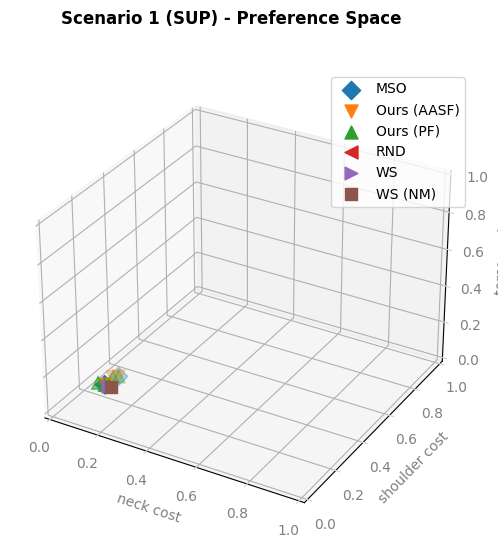

In [13]:
# Visualize the results in the preference space
def visualize_results_preference_space(data, adaptations, title):
    """Visualize the results in the preference space."""
    # Get figure
    fig = plt.figure(figsize=(8, 6))
    # Set title
    fig.suptitle(title, fontweight="bold")
    # Set axes (either 2D or 3D, depending on the number of preference criteria)
    if len(list(adaptations.values())[0][0]["preference_values"].keys()) == 2:
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(111, projection="3d")
    # Set axes limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if len(list(adaptations.values())[0][0]["preference_values"].keys()) == 3:
        ax.set_zlim(0, 1)
    # Get preference criteria names
    preference_criteria_names = list(list(adaptations.values())[0][0]["preference_values"].keys())
    # Set axes labels
    ax.set_xlabel(f"{preference_criteria_names[0]} cost")
    ax.set_ylabel(f"{preference_criteria_names[1]} cost")
    if len(preference_criteria_names) == 3:
        ax.set_zlabel(f"{preference_criteria_names[2]} cost")
    # Set grid
    ax.grid(color='gray', linestyle='dashed', alpha=0.5)
    # Set spines to grey
    ax.spines["bottom"].set_color('lightgray')
    ax.spines["top"].set_color('lightgray')
    ax.spines["right"].set_color('lightgray')
    ax.spines["left"].set_color('lightgray')
    # Set the tick labels and axis labels color to grey
    ax.tick_params(axis="x", which="both", labelcolor='gray', color='lightgray')
    ax.tick_params(axis="y", which="both", labelcolor='gray', color='lightgray')
    if len(preference_criteria_names) == 3:
        ax.tick_params(axis="z", which="both", labelcolor='gray', color='lightgray')
    # Set the tick labels and axis labels color to grey
    ax.xaxis.label.set_color('gray')
    ax.yaxis.label.set_color('gray')
    if len(preference_criteria_names) == 3:
        ax.zaxis.label.set_color('gray')
    # Plot points
    markers = ["D", "v", "^", "<", ">", "s"]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    # Plot points
    for solver, solver_data in data.groupby("solver"):
        # Get adaptation
        suggested_adaptations = adaptations[solver]
        # Get color
        color = colors.pop(0)
        # Get marker
        marker = markers.pop(0)
        # Plot points
        if len(preference_criteria_names) == 2:
            ax.scatter(
                [adaptation["preference_values"][preference_criteria_names[0]] for adaptation in suggested_adaptations],
                [adaptation["preference_values"][preference_criteria_names[1]] for adaptation in suggested_adaptations],
                s=[adaptation["utility"] * 100 for adaptation in suggested_adaptations],
                c=color,
                marker=marker,
                label=solver,
            )
        else:
            ax.scatter(
                [adaptation["preference_values"][preference_criteria_names[0]] for adaptation in suggested_adaptations],
                [adaptation["preference_values"][preference_criteria_names[1]] for adaptation in suggested_adaptations],
                [adaptation["preference_values"][preference_criteria_names[2]] for adaptation in suggested_adaptations],
                s=[adaptation["utility"] * 100 for adaptation in suggested_adaptations],
                c=color,
                marker=marker,
                label=solver,
            )
    # Set legend
    ax.legend()
    # Return figure
    return fig

def visualize_scenario_1_preference_space(results, adaptations):
    """Visualize the results for scenario 1 in the preference space."""
    # Get data
    data = results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_preference_space(data, adaptations["SUP"], "Scenario 1 (SUP) - Preference Space")
    # Return figure
    return fig

fig_scenario_1_preference_space = visualize_scenario_1_preference_space(results, adaptations)

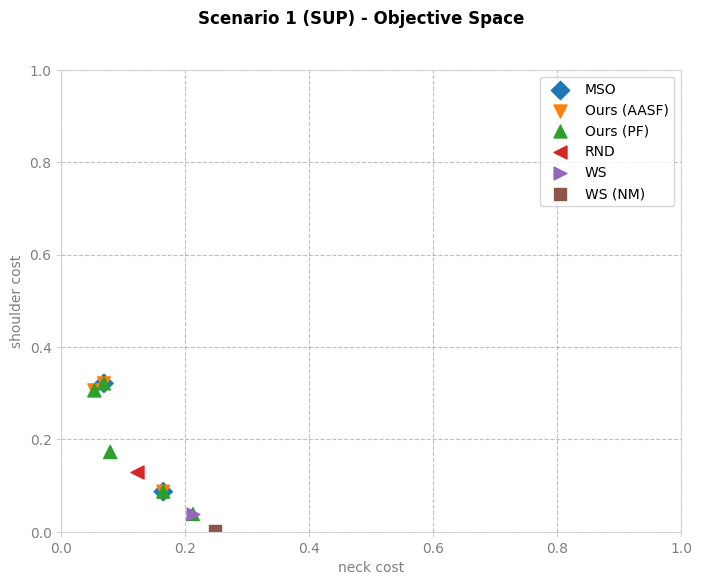

In [14]:
# Visualize the results in the objective space
def visualize_results_objective_space(data, adaptations, title):
    """Visualize the results in the objective space."""
    # Get figure
    fig = plt.figure(figsize=(8, 6))
    # Set title
    fig.suptitle(title, fontweight="bold")
    # Set axes (either 2D or 3D, depending on the number of preference criteria)
    if len(list(adaptations.values())[0][0]["objective_values"].keys()) == 2:
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(111, projection="3d")
    # Set axes limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if len(list(adaptations.values())[0][0]["objective_values"].keys()) == 3:
        ax.set_zlim(0, 1)
    # Get preference criteria names
    objective_criteria_names = list(list(adaptations.values())[0][0]["objective_values"].keys())
    # Set axes labels
    ax.set_xlabel(f"{objective_criteria_names[0]} cost")
    ax.set_ylabel(f"{objective_criteria_names[1]} cost")
    if len(objective_criteria_names) == 3:
        ax.set_zlabel(f"{objective_criteria_names[2]} cost")
    # Set grid
    ax.grid(color='gray', linestyle='dashed', alpha=0.5)
    # Set spines to grey
    ax.spines["bottom"].set_color('lightgray')
    ax.spines["top"].set_color('lightgray')
    ax.spines["right"].set_color('lightgray')
    ax.spines["left"].set_color('lightgray')
    # Set the tick labels and axis labels color to grey
    ax.tick_params(axis="x", which="both", labelcolor='gray', color='lightgray')
    ax.tick_params(axis="y", which="both", labelcolor='gray', color='lightgray')
    if len(objective_criteria_names) == 3:
        ax.tick_params(axis="z", which="both", labelcolor='gray', color='lightgray')
    # Set the tick labels and axis labels color to grey
    ax.xaxis.label.set_color('gray')
    ax.yaxis.label.set_color('gray')
    if len(objective_criteria_names) == 3:
        ax.zaxis.label.set_color('gray')
    # Plot points
    markers = ["D", "v", "^", "<", ">", "s"]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    # Plot points
    for solver, solver_data in data.groupby("solver"):
        # Get adaptation
        suggested_adaptations = adaptations[solver]
        # Get color
        color = colors.pop(0)
        # Get marker
        marker = markers.pop(0)
        # Plot points
        if len(objective_criteria_names) == 2:
            ax.scatter(
                [adaptation["objective_values"][objective_criteria_names[0]] for adaptation in suggested_adaptations],
                [adaptation["objective_values"][objective_criteria_names[1]] for adaptation in suggested_adaptations],
                s=[adaptation["utility"] * 100 for adaptation in suggested_adaptations],
                c=color,
                marker=marker,
                label=solver,
            )
        else:
            ax.scatter(
                [adaptation["objective_values"][objective_criteria_names[0]] for adaptation in suggested_adaptations],
                [adaptation["objective_values"][objective_criteria_names[1]] for adaptation in suggested_adaptations],
                [adaptation["objective_values"][objective_criteria_names[2]] for adaptation in suggested_adaptations],
                s=[adaptation["utility"] * 100 for adaptation in suggested_adaptations],
                c=color,
                marker=marker,
                label=solver,
            )
    # Set legend
    ax.legend()
    # Return figure
    return fig

def visualize_scenario_1_objective_space(results, adaptations):
    """Visualize the results for scenario 1 in the objective space."""
    # Get data
    data = results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_objective_space(data, adaptations["SUP"], "Scenario 1 (SUP) - Objective Space")
    # Return figure
    return fig

fig_scenario_1_objective_space = visualize_scenario_1_objective_space(results, adaptations)

## Scenario 2: Preference Criteria are Subset of Objectives (SUB)

In this second scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives include all preference criteria in the true preference function as well as one additional objective.

In [15]:
# Get utility function
SCENARIO_2_PREFERENCE_CRITERIA = ["neck", "shoulder"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_2_PREFERENCE_CRITERIA,
    weights=1/2,
)

# Get MOO problem
SCENARIO_2_OBJECTIVES = ["neck", "shoulder", "torso"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_2_OBJECTIVES
)

# Prepare dict to store the results
adaptations["SUB"] = {}

### Our Solver: U-NSGA-III w/ AASF

In [16]:
aasf_adaptations, utilities_for_aasf_adaptations = get_pareto_optimal_aasf_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)
adaptations["SUB"]["Ours (AASF)"] = []
for aasf_adaptation, utility in zip(aasf_adaptations, utilities_for_aasf_adaptations):
    adaptations["SUB"]["Ours (AASF)"].append({
        "utility": utility,
        "adaptation": aasf_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(aasf_adaptation)
            for preference_criteria in SCENARIO_2_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(aasf_adaptation)
            for objective in SCENARIO_2_OBJECTIVES
        },
    })

Adaptations (Ours (AASF)): 1 adaptations
Utilities (Ours (AASF)): [0.7725469797469134]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Max Utility (Ours (AASF)): 0.7725469797469134


In [17]:
pareto_front_adaptations, utilities_for_pareto_front_adaptations = get_pareto_optimal_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)
adaptations["SUB"]["Ours (PF)"] = []
for pareto_front_adaptation, utility in zip(pareto_front_adaptations, utilities_for_pareto_front_adaptations):
    adaptations["SUB"]["Ours (PF)"].append({
        "utility": utility,
        "adaptation": pareto_front_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(pareto_front_adaptation)
            for preference_criteria in SCENARIO_2_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(pareto_front_adaptation)
            for objective in SCENARIO_2_OBJECTIVES
        },
    })

Adaptations (Ours (PF)): 1 adaptations
Utilities (Ours (PF)): [0.7725469797469134]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Max Utility (Ours (PF)): 0.7725469797469134


### Baseline Solver 1: Static Weighted Sum (WS)

In [18]:
equally_weighted_sum_adaptation, equally_weighted_sum_utility = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)
adaptations["SUB"]["WS"] = [{
    "utility": equally_weighted_sum_utility,
    "adaptation": equally_weighted_sum_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation)
        for preference_criteria in SCENARIO_2_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation)
        for objective in SCENARIO_2_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Equally Weighted Sum Utility: 0.7725469797469134


In [19]:
equally_weighted_sum_adaptation_nm, equally_weighted_sum_utility_nm = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True, algo="nm")
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "WS (NM)",
    "utility": equally_weighted_sum_utility_nm,
}, ignore_index=True)
adaptations["SUB"]["WS (NM)"] = [{
    "utility": equally_weighted_sum_utility_nm,
    "adaptation": equally_weighted_sum_adaptation_nm,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation_nm)
        for preference_criteria in SCENARIO_2_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation_nm)
        for objective in SCENARIO_2_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=-20.0, y=-0.4081660276907719, z=11.088548143774597), rotation=Rotation(x=0.6928140338599005, y=0.22660605323139293, z=0.9616703921692736, w=0.0))])
Equally Weighted Sum Utility: 0.8739562000148


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

In [20]:
mso_adaptations, utilities_for_mso_adaptations = get_single_objective_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)
adaptations["SUB"]["MSO"] = []
for mso_adaptation, utility in zip(mso_adaptations, utilities_for_mso_adaptations):
    adaptations["SUB"]["MSO"].append({
        "utility": utility,
        "adaptation": mso_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(mso_adaptation)
            for preference_criteria in SCENARIO_2_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(mso_adaptation)
            for objective in SCENARIO_2_OBJECTIVES
        },
    })

Adaptations (MSO): 3 adaptations
Utilities (MSO): [0.7725469797469134, 0.7725469797469134, 0.7725469797469134]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Max Utility (MSO): 0.7725469797469134


### Baseline Solver 3: Random Solver (RND)

In [21]:
random_adaptation, expected_utility_for_random_adaptation = get_random_adaptation_and_expected_utility(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)
adaptations["SUB"]["RND"] = [{
    "utility": expected_utility_for_random_adaptation,
    "adaptation": random_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(random_adaptation)
        for preference_criteria in SCENARIO_2_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(random_adaptation)
        for objective in SCENARIO_2_OBJECTIVES
    },
}]

Median Utility Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=-6.865551799812447, y=1.4173915932001258, z=13.942419550944983), rotation=Rotation(x=0.652587340560102, y=0.8043918279470774, z=0.5327222760657402, w=0.6329176292676207))])
Median Utility (RND): 0.8583729729101615


### Results

In [22]:
# Show results
results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
9,SUB,"neck, shoulder","neck, shoulder, torso",WS (NM),0.873956
11,SUB,"neck, shoulder","neck, shoulder, torso",RND,0.858373
6,SUB,"neck, shoulder","neck, shoulder, torso",Ours (AASF),0.772547
7,SUB,"neck, shoulder","neck, shoulder, torso",Ours (PF),0.772547
8,SUB,"neck, shoulder","neck, shoulder, torso",WS,0.772547
10,SUB,"neck, shoulder","neck, shoulder, torso",MSO,0.772547


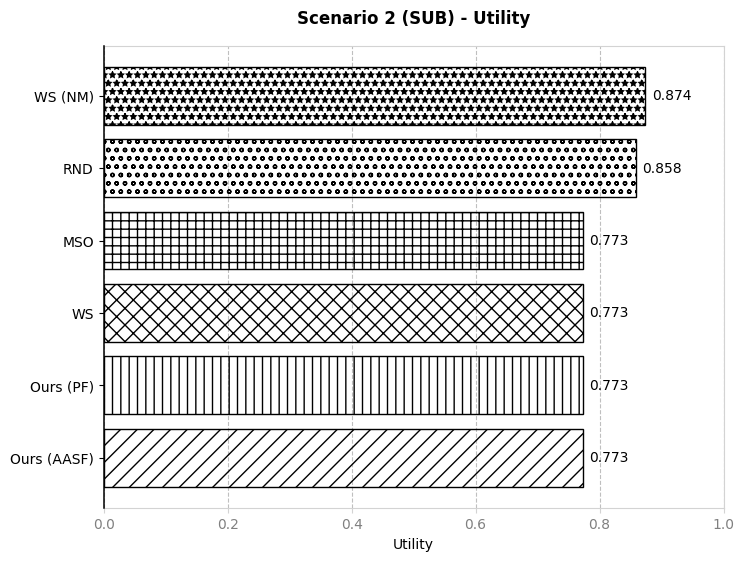

In [23]:
def visualize_scenario_2(results):
    """Visualize the results for scenario 2."""
    # Get data
    data = results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 2 (SUB) - Utility")
    # Return figure
    return fig

fig_scenario_2 = visualize_scenario_2(results)

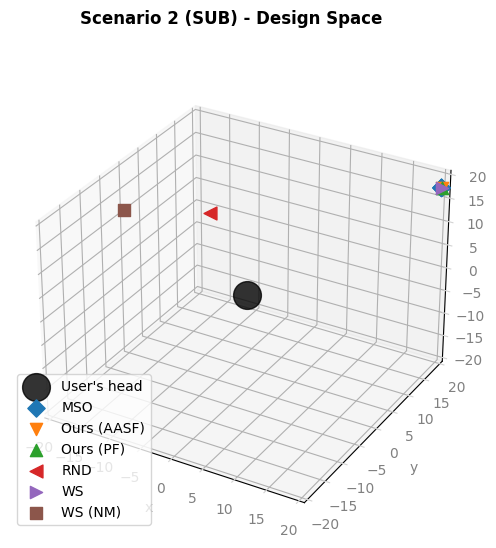

In [24]:
def visualize_scenario_2_3d(results, adaptations):
    """Visualize the results for scenario 2 in 3D."""
    # Get data
    data = results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_3d(data, adaptations["SUB"], "Scenario 2 (SUB) - Design Space")
    # Return figure
    return fig

fig_scenario_2_3d = visualize_scenario_2_3d(results, adaptations)

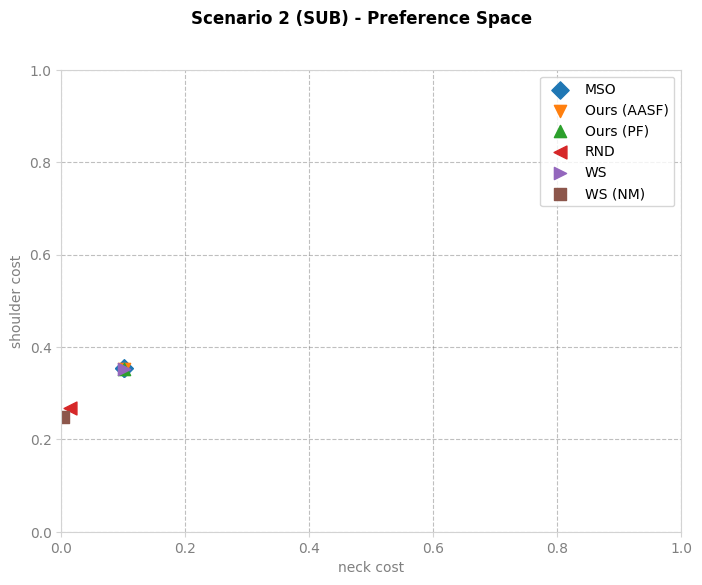

In [25]:
# Visualize adaptations in preference space
def visualize_scenario_2_preference_space(results, adaptations):
    """Visualize the results for scenario 2 in the preference space."""
    # Get data
    data = results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_preference_space(data, adaptations["SUB"], "Scenario 2 (SUB) - Preference Space")
    # Return figure
    return fig

fig_scenario_2_preference_space = visualize_scenario_2_preference_space(results, adaptations)

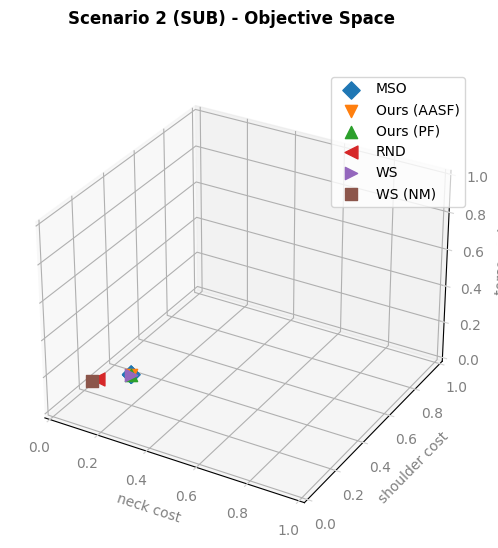

In [26]:
def visualize_scenario_2_objective_space(results, adaptations):
    """Visualize the results for scenario 2 in the objective space."""
    # Get data
    data = results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_objective_space(data, adaptations["SUB"], "Scenario 2 (SUB) - Objective Space")
    # Return figure
    return fig

fig_scenario_2_objective_space = visualize_scenario_2_objective_space(results, adaptations)

## Scenario 3: Preference Criteria are Disjoint from Objectives (DIS)

In this third scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives do not include any preference criteria in the true preference function.

In [27]:
# Get utility function
SCENARIO_3_PREFERENCE_CRITERIA = ["neck", "shoulder"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_3_PREFERENCE_CRITERIA,
    weights=1/2,
)

# Get MOO problem
SCENARIO_3_OBJECTIVES = ["torso", "reach"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_3_OBJECTIVES
)

# Prepare dict to store the results
adaptations["DIS"] = {}

### Our Solver: U-NSGA-III w/ AASF

In [28]:
aasf_adaptations, utilities_for_aasf_adaptations = get_pareto_optimal_aasf_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)
adaptations["DIS"]["Ours (AASF)"] = []
for aasf_adaptation, utility in zip(aasf_adaptations, utilities_for_aasf_adaptations):
    adaptations["DIS"]["Ours (AASF)"].append({
        "utility": utility,
        "adaptation": aasf_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(aasf_adaptation)
            for preference_criteria in SCENARIO_3_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(aasf_adaptation)
            for objective in SCENARIO_3_OBJECTIVES
        },
    })

Adaptations (Ours (AASF)): 1 adaptations
Utilities (Ours (AASF)): [0.8735215646219225]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Max Utility (Ours (AASF)): 0.8735215646219225


In [29]:
pareto_front_adaptations, utilities_for_pareto_front_adaptations = get_pareto_optimal_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)
adaptations["DIS"]["Ours (PF)"] = []
for pareto_front_adaptation, utility in zip(pareto_front_adaptations, utilities_for_pareto_front_adaptations):
    adaptations["DIS"]["Ours (PF)"].append({
        "utility": utility,
        "adaptation": pareto_front_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(pareto_front_adaptation)
            for preference_criteria in SCENARIO_3_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(pareto_front_adaptation)
            for objective in SCENARIO_3_OBJECTIVES
        },
    })

Adaptations (Ours (PF)): 1 adaptations
Utilities (Ours (PF)): [0.8735215646219225]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Max Utility (Ours (PF)): 0.8735215646219225


### Baseline Solver 1: Static Weighted Sum (WS)

In [30]:
equally_weighted_sum_adaptation, equally_weighted_sum_utility = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)
adaptations["DIS"]["WS"] = [{
    "utility": equally_weighted_sum_utility,
    "adaptation": equally_weighted_sum_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation)
        for preference_criteria in SCENARIO_3_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation)
        for objective in SCENARIO_3_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Equally Weighted Sum Utility: 0.8735215646219225


In [31]:
equally_weighted_sum_adaptation_nm, equally_weighted_sum_utility_nm = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True, algo="nm")
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "WS (NM)",
    "utility": equally_weighted_sum_utility_nm,
}, ignore_index=True)
adaptations["DIS"]["WS (NM)"] = [{
    "utility": equally_weighted_sum_utility_nm,
    "adaptation": equally_weighted_sum_adaptation_nm,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation_nm)
        for preference_criteria in SCENARIO_3_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation_nm)
        for objective in SCENARIO_3_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=0.012075786804327453, y=-0.657930329492942, z=-0.017423798672457552), rotation=Rotation(x=0.7519116451968757, y=0.0174478712123698, z=0.7605738159320687, w=0.8923909888949928))])
Equally Weighted Sum Utility: 0.8728555159356594


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

In [32]:
mso_adaptations, utilities_for_mso_adaptations = get_single_objective_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)
adaptations["DIS"]["MSO"] = []
for mso_adaptation, utility in zip(mso_adaptations, utilities_for_mso_adaptations):
    adaptations["DIS"]["MSO"].append({
        "utility": utility,
        "adaptation": mso_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(mso_adaptation)
            for preference_criteria in SCENARIO_3_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(mso_adaptation)
            for objective in SCENARIO_3_OBJECTIVES
        },
    })

Adaptations (MSO): 2 adaptations
Utilities (MSO): [0.8735215646219225, 0.8735215646219225]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Max Utility (MSO): 0.8735215646219225


### Baseline Solver 3: Random Solver (RND)

In [33]:
random_adaptation, expected_utility_for_random_adaptation = get_random_adaptation_and_expected_utility(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)
adaptations["DIS"]["RND"] = [{
    "utility": expected_utility_for_random_adaptation,
    "adaptation": random_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(random_adaptation)
        for preference_criteria in SCENARIO_3_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(random_adaptation)
        for objective in SCENARIO_3_OBJECTIVES
    },
}]

Median Utility Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=-6.865551799812447, y=1.4173915932001258, z=13.942419550944983), rotation=Rotation(x=0.652587340560102, y=0.8043918279470774, z=0.5327222760657402, w=0.6329176292676207))])
Median Utility (RND): 0.8583729729101615


### Results

In [34]:
# Show results
results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
12,DIS,"neck, shoulder","torso, reach",Ours (AASF),0.873522
13,DIS,"neck, shoulder","torso, reach",Ours (PF),0.873522
14,DIS,"neck, shoulder","torso, reach",WS,0.873522
16,DIS,"neck, shoulder","torso, reach",MSO,0.873522
15,DIS,"neck, shoulder","torso, reach",WS (NM),0.872856
17,DIS,"neck, shoulder","torso, reach",RND,0.858373


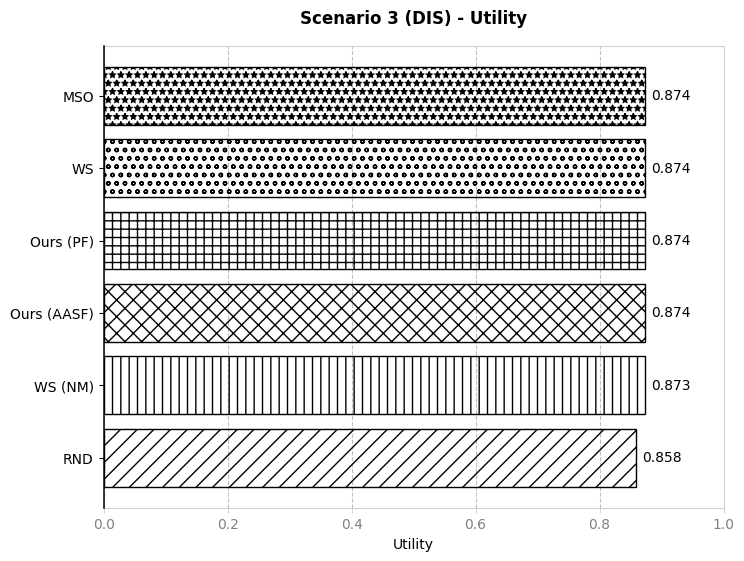

In [35]:
def visualize_scenario_3(results):
    """Visualize the results for scenario 3."""
    # Get data
    data = results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 3 (DIS) - Utility")
    # Return figure
    return fig

fig_scenario_3 = visualize_scenario_3(results)

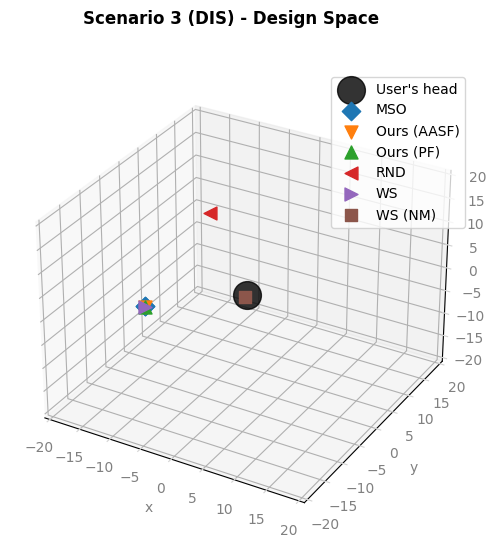

In [36]:
def visualize_scenario_3_3d(results, adaptations):
    """Visualize the results for scenario 3 in 3D."""
    # Get data
    data = results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_3d(data, adaptations["DIS"], "Scenario 3 (DIS) - Design Space")
    # Return figure
    return fig

fig_scenario_3_3d = visualize_scenario_3_3d(results, adaptations)

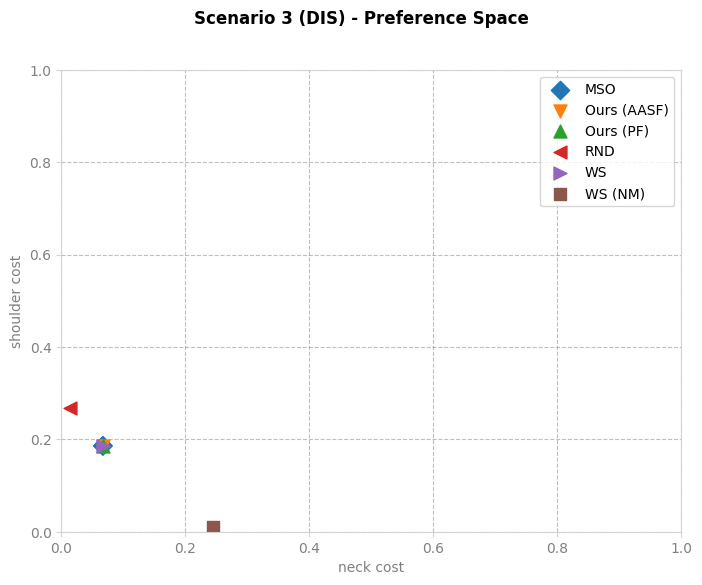

In [37]:
# Visualize adaptations in preference space
def visualize_scenario_3_preference_space(results, adaptations):
    """Visualize the results for scenario 3 in the preference space."""
    # Get data
    data = results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_preference_space(data, adaptations["DIS"], "Scenario 3 (DIS) - Preference Space")
    # Return figure
    return fig

fig_scenario_3_preference_space = visualize_scenario_3_preference_space(results, adaptations)

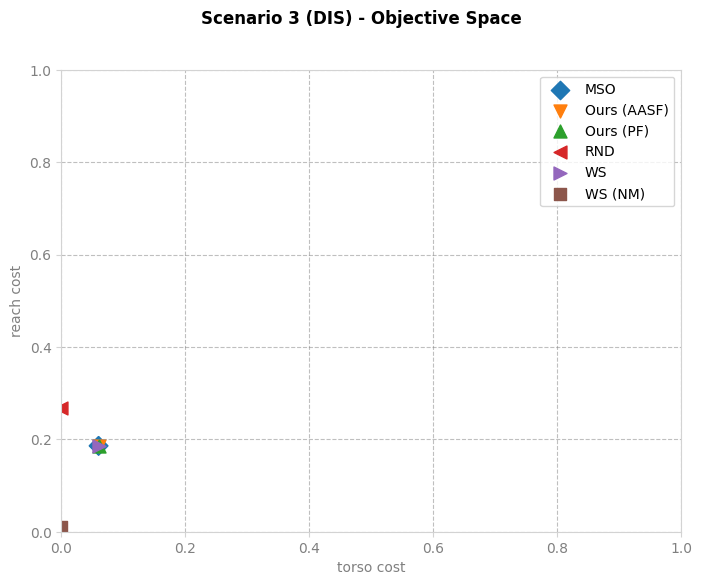

In [38]:
def visualize_scenario_3_objective_space(results, adaptations):
    """Visualize the results for scenario 3 in the objective space."""
    # Get data
    data = results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_objective_space(data, adaptations["DIS"], "Scenario 3 (DIS) - Objective Space")
    # Return figure
    return fig

fig_scenario_3_objective_space = visualize_scenario_3_objective_space(results, adaptations)

## Scenario 4: Preference Criteria are Equal to Objectives (EQU)

In this fourth scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives are equal to the preference criteria in the true preference function.

In [39]:
# Get utility function
SCENARIO_4_PREFERENCE_CRITERIA = ["neck", "shoulder"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_4_PREFERENCE_CRITERIA,
    weights=1/2,
)

# Get MOO problem
SCENARIO_4_OBJECTIVES = SCENARIO_4_PREFERENCE_CRITERIA
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_4_OBJECTIVES
)

# Prepare dict to store the results
adaptations["EQU"] = {}

### Our Solver: U-NSGA-III w/ AASF

In [40]:
aasf_adaptations, utilities_for_aasf_adaptations = get_pareto_optimal_aasf_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)
adaptations["EQU"]["Ours (AASF)"] = []
for aasf_adaptation, utility in zip(aasf_adaptations, utilities_for_aasf_adaptations):
    adaptations["EQU"]["Ours (AASF)"].append({
        "utility": utility,
        "adaptation": aasf_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(aasf_adaptation)
            for preference_criteria in SCENARIO_4_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(aasf_adaptation)
            for objective in SCENARIO_4_OBJECTIVES
        },
    })

Adaptations (Ours (AASF)): 3 adaptations
Utilities (Ours (AASF)): [0.8204057386268551, 0.8050347069584053, 0.874409927826035]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=2.9663322755596555, y=-18.01154136404964, z=10.313844418574764), rotation=Rotation(x=0.003475514504371763, y=0.13566018614764658, z=0.23471457278123978, w=0.7570932606281165))])
Max Utility (Ours (AASF)): 0.874409927826035


In [41]:
pareto_front_adaptations, utilities_for_pareto_front_adaptations = get_pareto_optimal_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)
adaptations["EQU"]["Ours (PF)"] = []
for pareto_front_adaptation, utility in zip(pareto_front_adaptations, utilities_for_pareto_front_adaptations):
    adaptations["EQU"]["Ours (PF)"].append({
        "utility": utility,
        "adaptation": pareto_front_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(pareto_front_adaptation)
            for preference_criteria in SCENARIO_4_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(pareto_front_adaptation)
            for objective in SCENARIO_4_OBJECTIVES
        },
    })

Adaptations (Ours (PF)): 5 adaptations
Utilities (Ours (PF)): [0.8050347069584053, 0.8204057386268551, 0.8747208162787068, 0.8742635008058796, 0.874409927826035]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Max Utility (Ours (PF)): 0.8747208162787068


### Baseline Solver 1: Static Weighted Sum (WS)

In [42]:
equally_weighted_sum_adaptation, equally_weighted_sum_utility = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)
adaptations["EQU"]["WS"] = [{
    "utility": equally_weighted_sum_utility,
    "adaptation": equally_weighted_sum_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation)
        for preference_criteria in SCENARIO_4_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation)
        for objective in SCENARIO_4_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Equally Weighted Sum Utility: 0.8747208162787068


In [43]:
equally_weighted_sum_adaptation_nm, equally_weighted_sum_utility_nm = get_equally_weighted_sum_adaptation_and_utility(problem, get_utility, verbose=True, algo="nm")
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "WS (NM)",
    "utility": equally_weighted_sum_utility_nm,
}, ignore_index=True)
adaptations["EQU"]["WS (NM)"] = [{
    "utility": equally_weighted_sum_utility_nm,
    "adaptation": equally_weighted_sum_adaptation_nm,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(equally_weighted_sum_adaptation_nm)
        for preference_criteria in SCENARIO_4_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(equally_weighted_sum_adaptation_nm)
        for objective in SCENARIO_4_OBJECTIVES
    },
}]

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=0.09306487238849481, y=-19.327692681427934, z=0.24956363297199857), rotation=Rotation(x=0.8249033331535464, y=0.3023882995904344, z=0.05397092199059141, w=0.9917847547031233))])
Equally Weighted Sum Utility: 0.874982713125225


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

In [44]:
mso_adaptations, utilities_for_mso_adaptations = get_single_objective_adaptations_and_utilities(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)
adaptations["EQU"]["MSO"] = []
for mso_adaptation, utility in zip(mso_adaptations, utilities_for_mso_adaptations):
    adaptations["EQU"]["MSO"].append({
        "utility": utility,
        "adaptation": mso_adaptation,
        "preference_values": {
            preference_criteria: experiments.user.get_objective_function(preference_criteria)(mso_adaptation)
            for preference_criteria in SCENARIO_4_PREFERENCE_CRITERIA
        },
        "objective_values": {
            objective: experiments.user.get_objective_function(objective)(mso_adaptation)
            for objective in SCENARIO_4_OBJECTIVES
        },
    })

Adaptations (MSO): 2 adaptations
Utilities (MSO): [0.874409927826035, 0.8050347069584053]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=2.9663322755596555, y=-18.01154136404964, z=10.313844418574764), rotation=Rotation(x=0.003475514504371763, y=0.13566018614764658, z=0.23471457278123978, w=0.7570932606281165))])
Max Utility (MSO): 0.874409927826035


### Baseline Solver 3: Random Solver (RND)

In [45]:
random_adaptation, expected_utility_for_random_adaptation = get_random_adaptation_and_expected_utility(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)
adaptations["EQU"]["RND"] = [{
    "utility": expected_utility_for_random_adaptation,
    "adaptation": random_adaptation,
    "preference_values": {
        preference_criteria: experiments.user.get_objective_function(preference_criteria)(random_adaptation)
        for preference_criteria in SCENARIO_4_PREFERENCE_CRITERIA
    },
    "objective_values": {
        objective: experiments.user.get_objective_function(objective)(random_adaptation)
        for objective in SCENARIO_4_OBJECTIVES
    },
}]

Median Utility Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=-6.865551799812447, y=1.4173915932001258, z=13.942419550944983), rotation=Rotation(x=0.652587340560102, y=0.8043918279470774, z=0.5327222760657402, w=0.6329176292676207))])
Median Utility (RND): 0.8583729729101615


### Results

In [46]:
# Show results
results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
21,EQU,"neck, shoulder","neck, shoulder",WS (NM),0.874983
19,EQU,"neck, shoulder","neck, shoulder",Ours (PF),0.874721
20,EQU,"neck, shoulder","neck, shoulder",WS,0.874721
18,EQU,"neck, shoulder","neck, shoulder",Ours (AASF),0.874410
22,EQU,"neck, shoulder","neck, shoulder",MSO,0.874410
23,EQU,"neck, shoulder","neck, shoulder",RND,0.858373


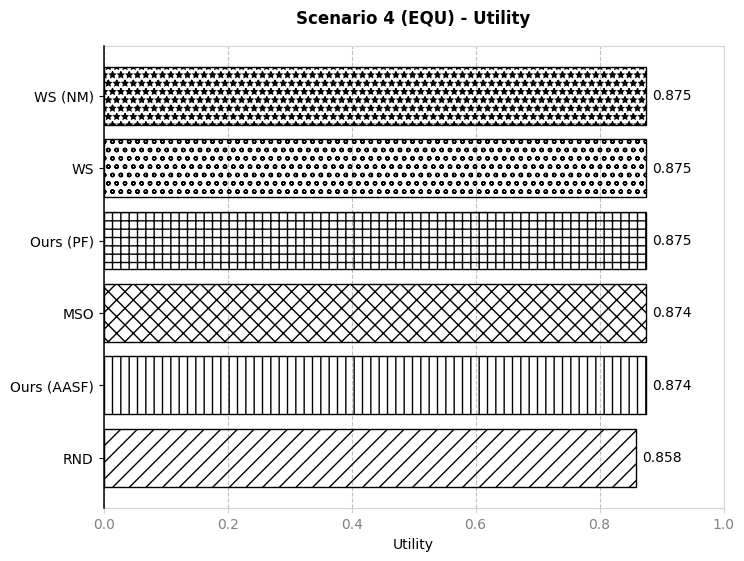

In [47]:
def visualize_scenario_4(results):
    """Visualize the results for scenario 4."""
    # Get data
    data = results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 4 (EQU) - Utility")
    # Return figure
    return fig

fig_scenario_4 = visualize_scenario_4(results)

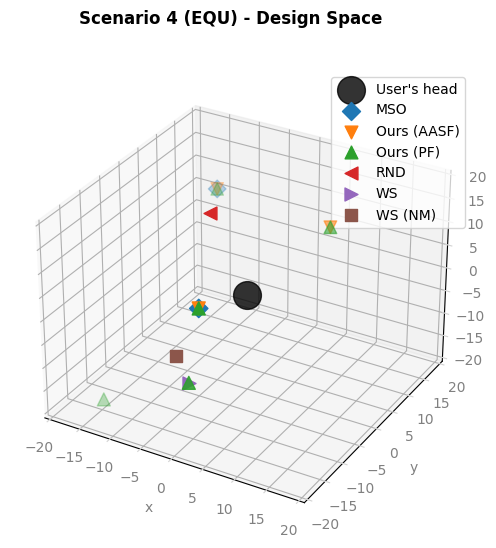

In [48]:
def visualize_scenario_4_3d(results, adaptations):
    """Visualize the results for scenario 4 in 3D."""
    # Get data
    data = results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_3d(data, adaptations["EQU"], "Scenario 4 (EQU) - Design Space")
    # Return figure
    return fig

fig_scenario_4_3d = visualize_scenario_4_3d(results, adaptations)

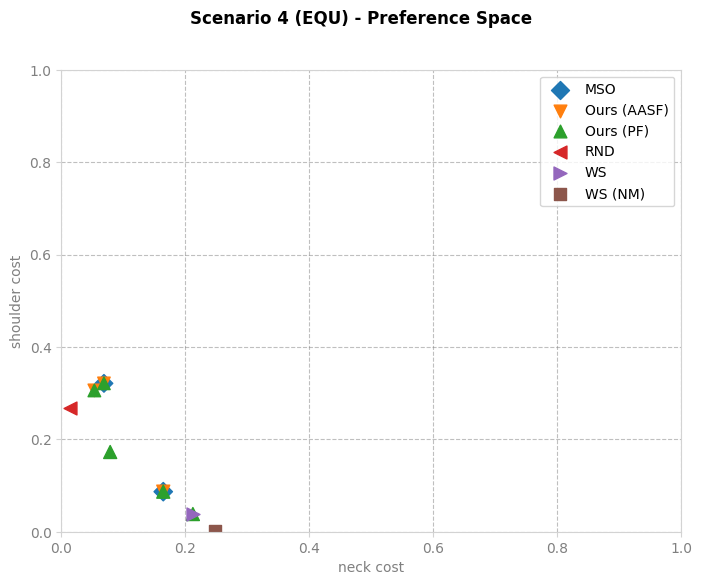

In [49]:
# Visualize adaptations in preference space
def visualize_scenario_4_preference_space(results, adaptations):
    """Visualize the results for scenario 4 in the preference space."""
    # Get data
    data = results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_preference_space(data, adaptations["EQU"], "Scenario 4 (EQU) - Preference Space")
    # Return figure
    return fig

fig_scenario_4_preference_space = visualize_scenario_4_preference_space(results, adaptations)

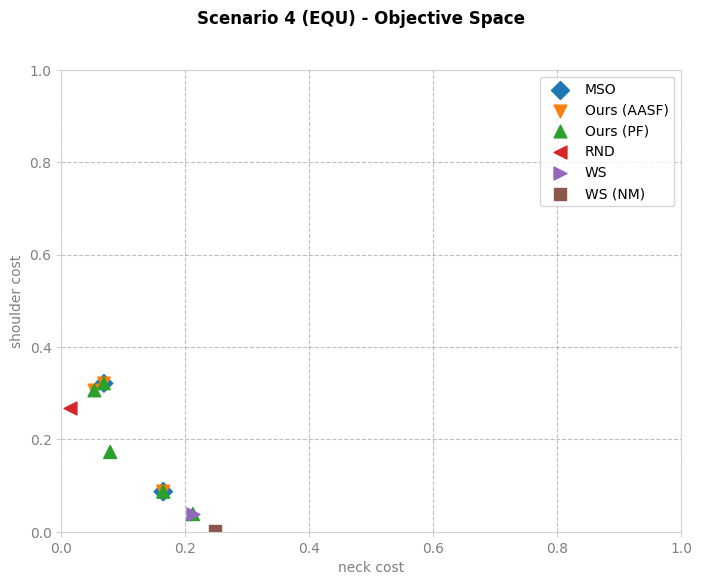

In [50]:
def visualize_scenario_4_objective_space(results, adaptations):
    """Visualize the results for scenario 4 in the objective space."""
    # Get data
    data = results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results_objective_space(data, adaptations["EQU"], "Scenario 4 (EQU) - Objective Space")
    # Return figure
    return fig

fig_scenario_4_objective_space = visualize_scenario_4_objective_space(results, adaptations)